## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [2]:
#!pip install wordcloud

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = '/Users/I500955/Documents/PG/Semantic Processing/complaints-2021-05-14_08_16.json'
  
# returns JSON object as a dictionary 
with open(f) as json_file:
    data = json.load(json_file)

# Normalize JSON data and convert it into a DataFrame
df = pd.json_normalize(data)

print(df.head())

                _index      _type      _id  _score   _source.tags  \
0  complaint-public-v2  complaint  3211475     0.0           None   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember   
2  complaint-public-v2  complaint  3199379     0.0           None   
3  complaint-public-v2  complaint  2673060     0.0           None   
4  complaint-public-v2  complaint  3203545     0.0           None   

  _source.zip_code _source.complaint_id                       _source.issue  \
0            90301              3211475   Attempts to collect debt not owed   
1            319XX              3229299     Written notification about debt   
2            77069              3199379  Other features, terms, or problems   
3            48066              2673060      Trouble during payment process   
4            10473              3203545                    Fees or interest   

       _source.date_received _source.state  ... _source.company_response  \
0  2019-04-13T12:00:00-05:00      

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
print(df['_source.issue'].unique())

['Attempts to collect debt not owed' 'Written notification about debt'
 'Other features, terms, or problems' 'Trouble during payment process'
 'Fees or interest' 'Managing an account' 'Closing an account'
 'Incorrect information on your report' 'Improper use of your report'
 'Struggling to pay mortgage' 'Struggling to pay your loan'
 'Fraud or scam' 'Problems at the end of the loan or lease'
 'Problem with a purchase shown on your statement' 'Opening an account'
 'Getting a credit card' 'Problem caused by your funds being low'
 'Loan modification,collection,foreclosure' 'Trouble using your card'
 'Problem when making payments' 'Struggling to pay your bill'
 'Problem with a lender or other company charging your account'
 'Applying for a mortgage or refinancing an existing mortgage'
 'Advertising and marketing, including promotional offers'
 "Problem with a credit reporting company's investigation into an existing problem"
 "Cont'd attempts collect debt not owed" 'Closing on a mortgage'


In [5]:
# Analyzing the distribution of complaints across different issues to identify 
# the most common issues reported by consumers
print(df['_source.issue'].value_counts())

Loan modification,collection,foreclosure                                           9743
Managing an account                                                                7410
Loan servicing, payments, escrow account                                           5360
Problem with a purchase shown on your statement                                    4055
Account opening, closing, or management                                            3879
                                                                                   ... 
Unable to get credit report/credit score                                              1
Advertising, marketing or disclosures                                                 1
Problem with an overdraft                                                             1
Can't stop withdrawals from your bank account                                         1
Money was taken from your bank account on the wrong day or for the wrong amount       1
Name: _source.issue, Length: 154

In [6]:
product_counts = df['_source.product'].value_counts()
print(product_counts)

Mortgage                                                                        22725
Checking or savings account                                                     12147
Credit card or prepaid card                                                     10797
Credit card                                                                     10373
Bank account or service                                                          9816
Credit reporting, credit repair services, or other personal consumer reports     4310
Debt collection                                                                  3201
Money transfer, virtual currency, or money service                               1500
Consumer Loan                                                                    1029
Vehicle loan or lease                                                             892
Student loan                                                                      866
Money transfers                                       

In [7]:
sub_product_counts = df['_source.sub_product'].value_counts()
print(sub_product_counts)

Checking account                              17182
General-purpose credit card or charge card    10504
Other mortgage                                 8447
Conventional fixed mortgage                    4892
Credit reporting                               4172
                                              ...  
Gift or merchant card                             4
Government benefit payment card                   4
ID prepaid card                                   2
Medical debt                                      2
Electronic Benefit Transfer / EBT card            1
Name: _source.sub_product, Length: 72, dtype: int64


In [8]:
#print the column names
print(df.columns)

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [9]:
#Assign new column names
df = df.rename(columns=lambda x: x.replace('_source.', ''))
df = df.rename(columns={'complaint_what_happened': 'complaint'})
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   _index                     78313 non-null  object 
 1   _type                      78313 non-null  object 
 2   _id                        78313 non-null  object 
 3   _score                     78313 non-null  float64
 4   tags                       10900 non-null  object 
 5   zip_code                   71556 non-null  object 
 6   complaint_id               78313 non-null  object 
 7   issue                      78313 non-null  object 
 8   date_received              78313 non-null  object 
 9   state                      76322 non-null  object 
 10  consumer_disputed          78313 non-null  object 
 11  product                    78313 non-null  object 
 12  company_response           78313 non-null  object 
 13  company                    78313 non-null  obj

In [10]:
#Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].replace('', np.nan)
print(df.head())

                _index      _type      _id  _score           tags zip_code  \
0  complaint-public-v2  complaint  3211475     0.0           None    90301   
1  complaint-public-v2  complaint  3229299     0.0  Servicemember    319XX   
2  complaint-public-v2  complaint  3199379     0.0           None    77069   
3  complaint-public-v2  complaint  2673060     0.0           None    48066   
4  complaint-public-v2  complaint  3203545     0.0           None    10473   

  complaint_id                               issue              date_received  \
0      3211475   Attempts to collect debt not owed  2019-04-13T12:00:00-05:00   
1      3229299     Written notification about debt  2019-05-01T12:00:00-05:00   
2      3199379  Other features, terms, or problems  2019-04-02T12:00:00-05:00   
3      2673060      Trouble during payment process  2017-09-13T12:00:00-05:00   
4      3203545                    Fees or interest  2019-04-05T12:00:00-05:00   

  state  ...         company_response       

In [11]:
#Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    # Make text lowercase
    text = text.lower()
    
    # Remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    
    return text

df['complaint'] = df['complaint'].apply(preprocess_text)

print(df.head())

                 _index      _type      _id  _score           tags zip_code  \
1   complaint-public-v2  complaint  3229299     0.0  Servicemember    319XX   
2   complaint-public-v2  complaint  3199379     0.0           None    77069   
10  complaint-public-v2  complaint  3233499     0.0           None    104XX   
11  complaint-public-v2  complaint  3180294     0.0           None    750XX   
14  complaint-public-v2  complaint  3224980     0.0           None    920XX   

   complaint_id                                 issue  \
1       3229299       Written notification about debt   
2       3199379    Other features, terms, or problems   
10      3233499  Incorrect information on your report   
11      3180294  Incorrect information on your report   
14      3224980                   Managing an account   

                date_received state  ...         company_response  \
1   2019-05-01T12:00:00-05:00    GA  ...  Closed with explanation   
2   2019-04-02T12:00:00-05:00    TX  ...  Cl

In [13]:
#Write your function to Lemmatize the texts
nlp = spacy.load("en_core_web_sm")

def lemmatize_and_extract_nouns(text):
    doc = nlp(text)
    
    # Lemmatize tokens and extract only nouns
    lemmatized_nouns = []
    for token in doc:
        # Lemmatize token
        lemma = token.lemma_
        
        # Extract only nouns (NN)
        if token.pos_ == 'NOUN':
            lemmatized_nouns.append(lemma)
    
    # Join lemmatized nouns into a string
    lemmatized_text = ' '.join(lemmatized_nouns)
    
    return lemmatized_text

df['lemmatized_complaint'] = df['complaint'].apply(lemmatize_and_extract_nouns)

In [14]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint', 'lemmatized_complaint']].copy()

print(df_clean.head())

                                            complaint  \
1   good morning my name is xxxx xxxx and i apprec...   
2   i upgraded my xxxx xxxx card in  and was told ...   
10  chase card was reported on  however fraudulent...   
11  on  while trying to book a xxxx  xxxx  ticket ...   
14  my grand son give me check for  i deposit it i...   

                                 lemmatized_complaint  
1   morning name stop bank cardmember service debt...  
2   xxxx card agent anniversary date agent informa...  
10  card application identity consent service cred...  
11  xxxx ticket offer ticket reward card informati...  
14  son check chase account fund chase bank accoun...  


In [15]:
#Write your function to extract the POS tags 

def pos_tag(text):
    doc = nlp(text)
    
    # Lemmatize tokens and extract only nouns
    lemmatized_nouns = []
    for token in doc:
        lemma = token.lemma_
        
        if token.pos_ == 'NOUN':
            lemmatized_nouns.append(lemma)
    
    # Join lemmatized nouns into a string
    lemmatized_text = ' '.join(lemmatized_nouns)
    
    return lemmatized_text

#this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaint"].apply(pos_tag)

print(df_clean.head())

                                            complaint  \
1   good morning my name is xxxx xxxx and i apprec...   
2   i upgraded my xxxx xxxx card in  and was told ...   
10  chase card was reported on  however fraudulent...   
11  on  while trying to book a xxxx  xxxx  ticket ...   
14  my grand son give me check for  i deposit it i...   

                                 lemmatized_complaint  \
1   morning name stop bank cardmember service debt...   
2   xxxx card agent anniversary date agent informa...   
10  card application identity consent service cred...   
11  xxxx ticket offer ticket reward card informati...   
14  son check chase account fund chase bank accoun...   

                                complaint_POS_removed  
1   morning name stop bank cardmember service debt...  
2   card agent anniversary date agent information ...  
10  card application identity consent service cred...  
11  xxxx ticket ticket reward card information min...  
14  account fund bank account mone

In [16]:
#clean dataframe with raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...
...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...
78310,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit chase credit card chase freedom balance...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




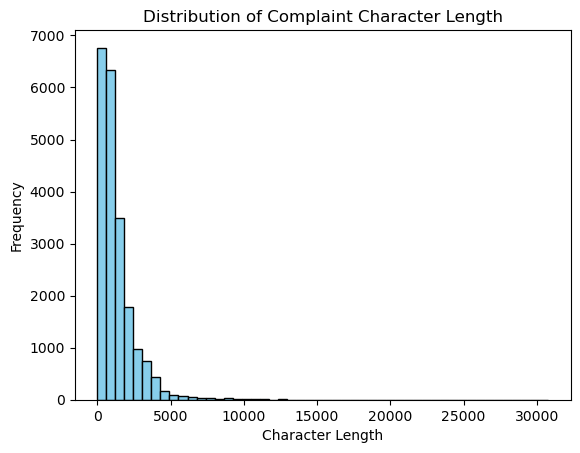

In [17]:
complaint_lengths = df_clean['complaint'].str.len()

plt.hist(complaint_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Character Length')
plt.show()


#### Find the top 40 words by frequency among all the articles after processing the text.

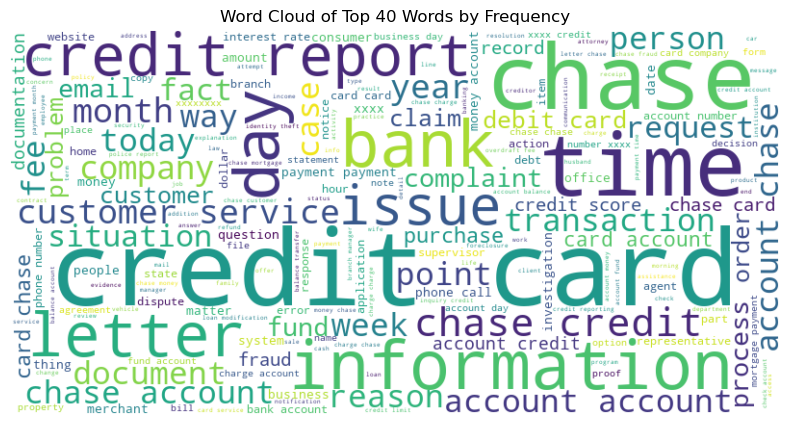

In [18]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all lemmatized complaint texts into a single string
all_complaints_text = ' '.join(df_clean['complaint_POS_removed'])

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_complaints_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top 40 Words by Frequency')
plt.show()

In [19]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the 'complaint_POS_removed' column
X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# Get feature names (unigrams)
feature_names = vectorizer.get_feature_names_out()

# Sum the occurrences of each unigram
unigram_freq = X.toarray().sum(axis=0)

# Combine feature names and frequencies
unigram_freq_dict = dict(zip(feature_names, unigram_freq))

# Sort the unigram frequencies in descending order
sorted_unigram_freq = sorted(unigram_freq_dict.items(), key=lambda x: x[1], reverse=True)

print("-------------Top 10 Unigrams----------")
for word, freq in sorted_unigram_freq[:10]:
    print(f'{word}: {freq}')

-------------Top 10 Unigrams----------
chase: 43190
account: 38866
credit: 32045
card: 29924
payment: 21083
time: 15835
bank: 13190
day: 12784
money: 11330
xxxx: 10845


In [21]:
# Initialize CountVectorizer to create bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')

# Fit and transform the 'complaint_POS_removed' column
X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the occurrences of each bigram
bigram_freq = X.toarray().sum(axis=0)

# Combine feature names and frequencies
bigram_freq_dict = dict(zip(feature_names, bigram_freq))

# Sort the bigram frequencies in descending order
sorted_bigram_freq = sorted(bigram_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 30 bigrams by frequency
print("----------Top 10 Bigrams by Frequency-------")
for bigram, freq in sorted_bigram_freq[:10]:
    print(f'{bigram}: {freq}')

----------Top 10 Bigrams by Frequency-------
credit card: 12813
credit report: 3737
chase credit: 2979
customer service: 2973
account account: 2677
chase account: 2639
account chase: 2420
debit card: 1869
card chase: 1755
card account: 1730


In [22]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')

# Fit and transform the 'complaint_POS_removed' column
X = vectorizer.fit_transform(df_clean['complaint_POS_removed'])

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Sum the occurrences of each bigram
trigram_freq = X.toarray().sum(axis=0)

# Combine feature names and frequencies
trigram_freq_dict = dict(zip(feature_names, trigram_freq))

# Sort the bigram frequencies in descending order
sorted_trigram_freq = sorted(trigram_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top 30 trigrams by frequency
print("----------Top 10 Trigrams by Frequency-------")
for trigram, freq in sorted_trigram_freq[:10]:
    print(f'{trigram}: {freq}')

----------Top 10 Trigrams by Frequency-------
chase credit card: 1957
credit card account: 1019
credit card company: 1003
credit card chase: 818
credit card credit: 616
xxxx credit card: 553
inquiry credit report: 523
card credit card: 494
account credit card: 464
credit report credit: 405


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [23]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [24]:
#All masked texts has been removed
df_clean

,complaint,lemmatized_complaint,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...,morning name stop bank cardmember service debt...
2,i upgraded my xxxx xxxx card in and was told ...,xxxx card agent anniversary date agent informa...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,chase card was reported on however fraudulent...,card application identity consent service cred...,card application identity consent service cred...,card application identity consent service cred...
11,on while trying to book a xxxx xxxx ticket ...,xxxx ticket offer ticket reward card informati...,xxxx ticket ticket reward card information min...,ticket ticket reward card information minute ...
14,my grand son give me check for i deposit it i...,son check chase account fund chase bank accoun...,account fund bank account money son money bank...,account fund bank account money son money bank...
...,...,...,...,...
78303,after being a chase card customer for well ove...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,xxxx credit card provider claim purchase prote...,xxxx credit card provider claim purchase prote...,credit card provider claim purchase protectio...
78310,i am not familiar with xxxx pay and did not un...,xxxx pay risk consumer chase bank app chase ye...,xxxx risk consumer chase year banking merchant...,risk consumer chase year banking merchant mer...
78311,i have had flawless credit for yrs ive had ch...,credit yrs chase credit card chase freedom pro...,credit chase credit card chase freedom balance...,credit chase credit card chase freedom balance...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [25]:
#Write your code here to initialise the TfidfVectorizer 

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [26]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print("TF-IDF Matrix Shape:", tfidf_matrix.shape)
print("First 10 Feature Names:", feature_names[:10])

TF-IDF Matrix Shape: (21072, 4867)
First 10 Feature Names: ['aarp' 'abandonment' 'abatement' 'abbreviation' 'abide' 'ability'
 'absence' 'absurdity' 'abundance' 'abuse']


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [27]:
from sklearn.decomposition import NMF

# Define the range of clusters to try
# num_clusters_range = [5, 10, 15, 20]

# # Initialize NMF model
# best_nmf_model = None
# best_num_clusters = 0
# best_nmf_topics = None
# best_nmf_transformed = None
# best_nmf_error = float('inf')

# for num_clusters in num_clusters_range:
#     # Initialize NMF with the current number of clusters
#     nmf_model = NMF(n_components=num_clusters, random_state=42)
    
#     # Fit the NMF model to the TF-IDF matrix
#     nmf_transformed = nmf_model.fit_transform(tfidf_matrix)
    
#     # Reconstruct the TF-IDF matrix
#     nmf_reconstructed = nmf_model.inverse_transform(nmf_transformed)
    
#     # Calculate the reconstruction error
#     reconstruction_error = np.linalg.norm(tfidf_matrix - nmf_reconstructed)
    
#     # Update the best model if this one has a lower reconstruction error
#     if reconstruction_error < best_nmf_error:
#         best_nmf_error = reconstruction_error
#         best_nmf_model = nmf_model
#         best_num_clusters = num_clusters
#         best_nmf_topics = nmf_model.components_
#         best_nmf_transformed = nmf_transformed

# # Inspect the topics for the best model
# print("Best Number of Clusters:", best_num_clusters)
# print("Reconstruction Error:", best_nmf_error)
# for i, topic in enumerate(best_nmf_topics):
#     print(f"Topic {i}:")
#     print([feature_names[j] for j in topic.argsort()[:-11:-1]])

Best Number of Clusters: 20
Reconstruction Error: 122.96604900990121
Topic 0:
['card', 'credit', 'purchase', 'year', 'month', 'point', 'debit', 'service', 'freedom', 'reward']
Topic 1:
['credit', 'report', 'score', 'limit', 'reporting', 'information', 'identity', 'agency', 'history', 'theft']
Topic 2:
['payment', 'month', 'statement', 'time', 'date', 'day', 'xxxxxxxx', 'auto', 'error', 'bank']
Topic 3:
['account', 'reason', 'year', 'activity', 'access', 'business', 'closure', 'banking', 'saving', 'identity']
Topic 4:
['loan', 'modification', 'rate', 'car', 'document', 'home', 'student', 'auto', 'year', 'application']
Topic 5:
['fee', 'overdraft', 'year', 'dollar', 'time', 'bank', 'xxxx', 'month', 'customer', 'service']
Topic 6:
['inquiry', 'report', 'authorization', 'application', 'verification', 'purpose', 'organization', 'section', 'date', 'method']
Topic 7:
['charge', 'fraud', 'statement', 'purchase', 'xxxx', 'time', 'xxxxxxxx', 'month', 'investigation', 'billing']
Topic 8:
['check'

In [32]:
def create_nmf_model(tfidf_matrix, num_clusters_range=[5, 10, 15, 20], random_state=42):
    best_nmf_model = None
    best_num_clusters = 0
    best_nmf_topics = None
    best_nmf_transformed = None
    best_nmf_error = float('inf')
    
    for num_clusters in num_clusters_range:
        # Initialize NMF with the current number of clusters
        nmf_model = NMF(n_components=num_clusters, random_state=random_state)
        
        # Fit the NMF model to the TF-IDF matrix
        nmf_transformed = nmf_model.fit_transform(tfidf_matrix)
        
        # Reconstruct the TF-IDF matrix
        nmf_reconstructed = nmf_model.inverse_transform(nmf_transformed)
        
        # Calculate the reconstruction error
        reconstruction_error = np.linalg.norm(tfidf_matrix - nmf_reconstructed)
        
        # Print the current status
        print(f"Number of Clusters: {num_clusters}")
        print(f"Reconstruction Error: {reconstruction_error}")
        print("Top Words per Topic:")
        for i, topic in enumerate(nmf_model.components_):
            top_words = [feature_names[j] for j in topic.argsort()[:-11:-1]]
            print(f"Topic {i}: {top_words}")
        print("=" * 50)
        
        # Update the best model if this one has a lower reconstruction error
        if reconstruction_error < best_nmf_error:
            best_nmf_error = reconstruction_error
            best_nmf_model = nmf_model
            best_num_clusters = num_clusters
            best_nmf_topics = nmf_model.components_
            best_nmf_transformed = nmf_transformed
    
    # Print the best result
    print("Best Number of Clusters:", best_num_clusters)
    print("Best Reconstruction Error:", best_nmf_error)
    print("Top Words per Topic for Best Model:")
    for i, topic in enumerate(best_nmf_topics):
        top_words = [feature_names[j] for j in topic.argsort()[:-11:-1]]
        print(f"Topic {i}: {top_words}")
    print("=" * 50)
    
    return best_nmf_error, best_nmf_model, best_num_clusters, best_nmf_topics, best_nmf_transformed

best_nmf_error, best_nmf_model, best_num_clusters, best_nmf_topics, best_nmf_transformed = create_nmf_model(tfidf_matrix)

Number of Clusters: 5
Reconstruction Error: 132.88666590911367
Top Words per Topic:
Topic 0: ['account', 'money', 'check', 'bank', 'fund', 'chase', 'day', 'deposit', 'branch', 'fee']
Topic 1: ['card', 'charge', 'chase', 'credit', 'dispute', 'purchase', 'service', 'fraud', 'xxxx', 'time']
Topic 2: ['payment', 'balance', 'month', 'fee', 'statement', 'day', 'time', 'date', 'chase', 'auto']
Topic 3: ['credit', 'report', 'inquiry', 'score', 'account', 'debt', 'card', 'company', 'information', 'reporting']
Topic 4: ['loan', 'mortgage', 'chase', 'home', 'modification', 'year', 'property', 'time', 'rate', 'document']
Number of Clusters: 10
Reconstruction Error: 128.63872050575492
Top Words per Topic:
Topic 0: ['chase', 'letter', 'number', 'information', 'phone', 'email', 'time', 'service', 'customer', 'dispute']
Topic 1: ['card', 'credit', 'chase', 'balance', 'limit', 'score', 'year', 'purchase', 'month', 'company']
Topic 2: ['payment', 'month', 'balance', 'statement', 'day', 'credit', 'chase'

In [31]:
# Apply the best number to create word clusters

def generate_word_clusters(nmf_model, feature_names, num_words=10):
    word_clusters = []
    for topic in nmf_model.components_:
        top_word_indices = topic.argsort()[:-num_words-1:-1]
        top_words = [feature_names[i] for i in top_word_indices]
        word_clusters.append(top_words)
    return word_clusters

# generate word clusters using the best number of clusters as follows:

word_clusters = generate_word_clusters(best_nmf_model, feature_names)

# Print the word clusters for each topic
for i, cluster in enumerate(word_clusters):
    print(f"Cluster {i}: {cluster}")

Cluster 0: ['card', 'credit', 'purchase', 'year', 'month', 'point', 'debit', 'service', 'freedom', 'reward']
Cluster 1: ['credit', 'report', 'score', 'limit', 'reporting', 'information', 'identity', 'agency', 'history', 'theft']
Cluster 2: ['payment', 'month', 'statement', 'time', 'date', 'day', 'xxxxxxxx', 'auto', 'error', 'bank']
Cluster 3: ['account', 'reason', 'year', 'activity', 'access', 'business', 'closure', 'banking', 'saving', 'identity']
Cluster 4: ['loan', 'modification', 'rate', 'car', 'document', 'home', 'student', 'auto', 'year', 'application']
Cluster 5: ['fee', 'overdraft', 'year', 'dollar', 'time', 'bank', 'xxxx', 'month', 'customer', 'service']
Cluster 6: ['inquiry', 'report', 'authorization', 'application', 'verification', 'purpose', 'organization', 'section', 'date', 'method']
Cluster 7: ['charge', 'fraud', 'statement', 'purchase', 'xxxx', 'time', 'xxxxxxxx', 'month', 'investigation', 'billing']
Cluster 8: ['check', 'bank', 'deposit', 'cashier', 'copy', 'signature'

In [33]:
def inspect_clusters(df, nmf_transformed, num_clusters):
    # Iterate through each cluster
    for cluster_id in range(num_clusters):
        # Find indices of complaints belonging to this cluster
        cluster_indices = np.where(np.argmax(nmf_transformed, axis=1) == cluster_id)[0]
        
        Print cluster information
        print(f"Cluster {cluster_id}:")
        for idx in cluster_indices:
            print(df.iloc[idx]['complaint'])
        print("=" * 50)
        
inspect_clusters(df_clean, best_nmf_transformed, best_num_clusters)

Cluster 0:
my chase amazon card was declined for a catering order i had placed for my brothers funeral in the amount of  i contacted chase around noon today  and was asked the last  numbers of my chase savings account and the other user on my account i responded that i did not have a savings and i am only authorized user customer rep told me they would call me back in  minutes to keep the line open i didnt receive a call back after an hour so i contacted chase from the first call i thought someone was using my card fraudulently i spoke to the rep who transferred me to a supervisor xxxx who said the card was activated and the transaction would process called the catering company and card was declined i then used my xxxx  xxxx card to pay for the order xxxx xxxx texted me asking if i was authorizing purchase and i responded yes contacted caterer and xxxx  xxxx was declined i contacted chase again spoke to rep was told the initial questions are used to trick people to see what there answe

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [34]:
cluster_topics = {
    0: "Credit card / Prepaid card",
    1: "Bank account services",
    2: "Theft/Dispute reporting",
    3: "Mortgages/loans",
    4: "Others"
}

# Assign cluster labels to the complaints in your DataFrame
df_clean['cluster_label'] = np.argmax(best_nmf_transformed, axis=1)
df_clean['topic'] = df_clean['cluster_label'].map(cluster_topics)

In [37]:
df_clean[['complaint', 'cluster_label', 'topic']]

,complaint,cluster_label,topic
1,good morning my name is xxxx xxxx and i apprec...,16,NaN
2,i upgraded my xxxx xxxx card in and was told ...,10,NaN
10,chase card was reported on however fraudulent...,1,Bank account services
11,on while trying to book a xxxx xxxx ticket ...,1,Bank account services
14,my grand son give me check for i deposit it i...,8,NaN
...,...,...,...
78303,after being a chase card customer for well ove...,0,Credit card / Prepaid card
78309,on wednesday xxxxxxxx i called chas my xxxx xx...,10,NaN
78310,i am not familiar with xxxx pay and did not un...,17,NaN
78311,i have had flawless credit for yrs ive had ch...,11,NaN


## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = #write the value you want to test out

#keep the random_state =40
nmf_model = #write your code here

In [ ]:
nmf_model.fit(dtm)
len(tfidf.get_feature_names())

In [ ]:
#Print the Top15 words for each of the topics


In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4



In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = #write your code to assign topics to each rows.

In [ ]:
df_clean.head()

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean=df_clean.groupby('Topic').head(5)
df_clean.sort_values('Topic')

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = {   }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [ ]:
df_clean

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=

In [ ]:
training_data

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:

#Write your code to get the Vector count


#Write your code here to transform the word vector to tf-idf

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics



